<a href="https://colab.research.google.com/github/skywalker0803r/works/blob/master/%E5%8D%97%E4%BA%9EPA%E5%BB%A0%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90_R6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import gc
drive.mount('/content/drive')
gc.collect()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


0

# Load data

In [2]:
import pandas as pd
from  tqdm import tqdm_notebook as tqdm

# load
path = '/content/drive/My Drive/南亞PA廠/PA_201605-201909R6.xlsx'
df = pd.read_excel(path,index_col=0,parse_dates = True)

# columns to_numeric
for col in tqdm(df.columns):
  df[col] = pd.to_numeric(df[col],errors='coerce')

# add target
df['target'] = df['MLPAP_FQI-0997.PV'] / df['MLPAP_FQ-0619.PV']

gc.collect()
# show
print(df.shape)
df.tail()


(58081, 72)


,MLPAP_TI-0706B02,MLPAP_TI-0706B03,MLPAP_TI-0706B04,MLPAP_TI-0706B05,MLPAP_TI-0706B06,MLPAP_TI-0706B07,MLPAP_TI-0706B08,MLPAP_TI-0706B09,MLPAP_TI-0706B10,MLPAP_TI-0706B11,MLPAP_TI-0706B12,MLPAP_TI-0706B13,MLPAP_TI-0706B14,MLPAP_TI-0706B15,MLPAP_TI-0706B16,MLPAP_TI-0706B17,MLPAP_TI-0706B18,MLPAP_TI-0706B19,MLPAP_TI-0706B20,MLPAP_TI-0706B21,MLPAP_TI-0706B22,MLPAP_TI-0706B23,MLPAP_TI-0706B24,MLPAP_TJR-0715A1.PV,MLPAP_TJR-0715A2.PV,MLPAP_TJR-0715B1.PV,MLPAP_TJR-0715B2.PV,MLPAP_TJR-0720A1.PV,MLPAP_TJR-0720A2.PV,MLPAP_TJR-0720B1.PV,MLPAP_TJR-0720B2.PV,MLPAP_TJR-0762A1.PV,MLPAP_TJR-0762A2.PV,MLPAP_TJR-0762B1.PV,MLPAP_TJR-0762B2.PV,MLPAP_TI-0706A02,MLPAP_TI-0706B01,MLPAP_TI-0706C01,MLPAP_TI-0706D01,MLPAP_TI-0716B01,MLPAP_TI-0716C01,MLPAP_TI-0716D01,MLPAP_TI-0716E01,MLPAP_TI-0716A01,MLPAP_TI-0706E01,MLPAP_TI-0706A01,MLPAP_TI-0716D02,MLPAP_TJC-0627.PV,MLPAP_TRC-0610.PV,MLPAP_FR-0632.PV,MLPAP_FQ-0619.PV,MLPAP_TIC-0757A.PV,MLPAP_TI-0757B.PV,MLPAP_PIC-0741.PV,MLPAP_LIC-0738.PV,MLPAP_PIC-0761.PV,MLPAP_TRC-0762.PV,MLPAP_LRC-0729.PV,MLPAP_TIC-1721.PV,MLPAP_TRC-1734.PV,MLPAP_TJR-0721.PV,MLPAP_FQI-0997.PV,DATA OF USE,MLPAP_FR-0755.PV,MLPAP_FR-0755PV(轉換後),MLPAP_FR-0791.PV,MLPAP_FI-V211.PV,MLPAP_FI-V211.PV(轉換後),MLPAP_PI-0658.PV,MLPAP_TIC-0757.PV,MLPAP_V125-PHD,target
2019-08-31 22:00:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,86.000000,86.0,86.0,86.0,86.0,86.000000,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.251274,82.400002,87.500824,81.800003,0.0,81.048729,83.500000,95.000000,0.0,92.500000,88.900002,87.900002,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,89.000000,85.0,83.0,29.351271,179.899994,0.0,0.0,50.0,0.0,0.3,86.529999,0.3,92.500000,0.0,61.402542,179.000000,65.900002,0.0,58077,4.53,4.523893,3.084818,128.298767,128.125806,-1.0,-50.0,0.008,NaN
2019-08-31 22:30:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,86.991974,86.0,86.0,86.0,86.0,85.008026,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.402390,82.500801,87.500801,81.699997,0.0,81.199997,83.500801,95.297592,0.0,92.548805,88.702408,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,89.000000,85.0,83.0,29.299999,179.899994,0.0,0.0,50.0,0.0,0.3,86.400002,0.3,92.500000,0.0,59.948807,180.800003,66.000000,0.0,58078,4.40,4.394068,1.527576,130.698090,130.521894,-1.0,-50.0,0.008,NaN
2019-08-31 23:00:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,86.992149,86.0,86.0,86.0,86.0,85.007851,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.295456,82.500000,87.699211,81.699997,0.0,81.204544,83.500786,95.000786,0.0,92.599998,88.900787,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,88.489616,85.0,83.0,29.248865,179.699997,0.0,0.0,50.0,0.0,0.3,86.490005,0.3,92.599998,0.0,60.590916,180.500000,66.099998,0.0,58079,4.57,4.563839,3.129686,129.700394,129.525543,-1.0,-50.0,0.008,NaN
2019-08-31 23:30:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,87.000000,86.0,86.0,86.0,86.0,86.000000,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.248802,82.500000,87.501686,81.800003,0.0,81.199997,83.599998,95.199150,0.0,92.599998,88.999191,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,88.000000,85.0,83.0,29.200001,179.600006,0.0,0.0,50.0,0.0,0.3,86.639999,0.3,92.599998,0.0,60.353588,173.600006,66.099998,0.0,58080,4.48,4.473960,3.697329,129.000000,128.826093,-1.0,-50.0,0.008,NaN
2019-09-01 00:00:00,88.0,88.0,87.0,88.0,87.0,87.0,87.0,87.0,87.000000,86.0,86.0,86.0,86.0,86.000000,85.0,85.0,84.0,85.0,84.0,82.0,83.0,84.0,83.0,88.199997,82.500824,87.699135,81.699997,0.0,81.253754,83.599998,95.100861,0.0,92.651245,88.900002,87.800003,88.0,81.0,88.0,82.0,93.0,81.0,89.0,106.0,87.0,88.511322,85.0,83.0,29.200001,179.800003,0.0,0.0,50.0,0.0,0.3,86.570000,0.3,92.699135,0.0,59.848751,180.500000,66.099998,0.0,58081,4.50,4.493933,2.785345,130.401550,130.225754,-1.0,-50.0,0.008,NaN


# Load tag盤點表

In [3]:
tag盤點表 = pd.read_excel('/content/drive/My Drive/南亞PA廠/tag盤點表.xlsx')
中文map = dict(zip(tag盤點表['TAG'],tag盤點表['chinese']))
tag盤點表.head()

,item,TAG,chinese,character,unit,category,period,min,max,推測顯著性(依製程經驗)
0,1.0,MLPAP_TJC-0627.PV,OX預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,140,160,***
1,2.0,MLPAP_TRC-0610.PV,空氣預熱器出口溫度,溫度,℃,可控制因子,1分鐘2筆,160,200,***
2,3.0,MLPAP_FR-0632.PV,汽機風量,流量,KNM3/HR,可控制因子,1分鐘2筆,30,90,****
3,4.0,MLPAP_FQ-0619.PV,OX入料量,流量,kg/HR,可控制因子,1分鐘2筆,2000,8000,****
4,5.0,MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,溫度,℃,可控制因子,1分鐘2筆,345,365,****


# 定義可控制因子

In [4]:
可控制因子 = list(tag盤點表[tag盤點表.category=="可控制因子"]['TAG'].values)
print('可控制因子數量:',len(可控制因子))

可控制因子數量: 13


# 全部欄位 corr

In [5]:
y_name = 'target'
all_corrs = abs(df.corr())[[y_name]].sort_values(by=y_name,ascending=False)
all_corrs['中文'] = all_corrs.index.map(中文map)
all_corrs = all_corrs[['中文',y_name]]
all_corrs.head(10)

,中文,target
target,NaN,1.000000
MLPAP_FQI-0997.PV,粗PA出料量,0.591380
MLPAP_FQ-0619.PV,OX入料量,0.337525
MLPAP_FR-0791.PV,反應槽50K蒸氣輸出,0.326117
MLPAP_TI-0706B09,反應槽溫度_多點式(高度 950),0.304193
MLPAP_TI-0706B08,反應槽溫度_多點式(高度 850),0.275929
MLPAP_TI-0706B10,反應槽溫度_多點式(高度 1050),0.247835
MLPAP_TI-0706E01,反應槽觸媒溫度(CL1)_高度(1310),0.211496
MLPAP_FR-0632.PV,汽機風量,0.208166
MLPAP_TI-0706B07,反應槽溫度_多點式(高度 750),0.199344


# 可控制因子 corr

In [6]:
y_name = 'target'
sub_corrs = abs(df[可控制因子+[y_name]].corr())[[y_name]].sort_values(by=y_name,ascending=False)
sub_corrs['中文'] = sub_corrs.index.map(中文map)
sub_corrs = sub_corrs[['中文',y_name]]
sub_corrs.head(10)

,中文,target
target,NaN,1.000000
MLPAP_FQ-0619.PV,OX入料量,0.337525
MLPAP_FR-0632.PV,汽機風量,0.208166
MLPAP_PIC-0761.PV,鹽浴冷卻器(E112)出口壓力,0.148769
MLPAP_TIC-0757A.PV,反應槽鹽浴溫度,0.115184
MLPAP_TIC-0757.PV,反應器A/B側鹽浴溫度差,0.098067
MLPAP_TRC-0762.PV,鹽浴冷卻器(E112)入口溫度,0.075499
MLPAP_LIC-0738.PV,汽鼓(V211)鍋爐水液位,0.061041
MLPAP_TJC-0627.PV,OX預熱器出口溫度,0.057344
MLPAP_TRC-0610.PV,空氣預熱器出口溫度,0.049615


# kdeplot

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings 
warnings.simplefilter('ignore')
gc.collect()

def kdeplot(df,x_col,y_col,y_ub=1.12,y_lb=1.09):
  
  sns.kdeplot(df.loc[df[y_col] > y_ub ,x_col],label = y_col + '>' +str(y_ub))
  sns.kdeplot(df.loc[df[y_col] < y_lb ,x_col],label = y_col + '<' +str(y_lb))
  plt.legend()
  
  try:
    print(pd.Series(x_col).map(中文map))
  except:
    pass
  
  plt.title(x_col)
  plt.show()

# 全部欄位排名前10 KDEPLOT

0    粗PA出料量
dtype: object


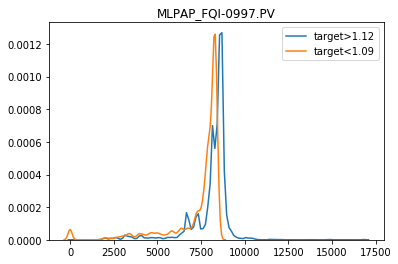

0    OX入料量
dtype: object


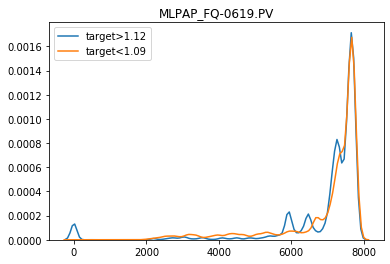

0    反應槽50K蒸氣輸出
dtype: object


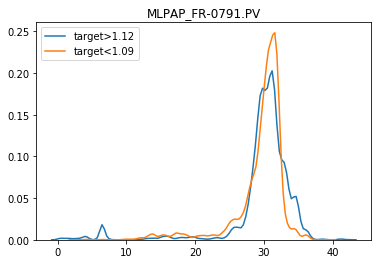

0    反應槽溫度_多點式(高度 950)
dtype: object


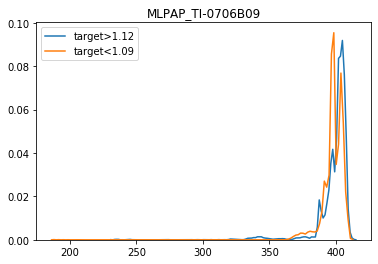

0    反應槽溫度_多點式(高度 850)
dtype: object


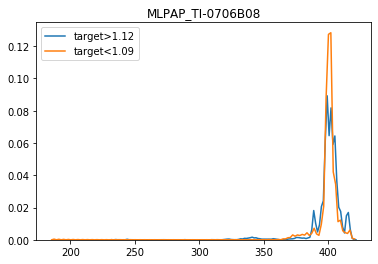

0    反應槽溫度_多點式(高度 1050)
dtype: object


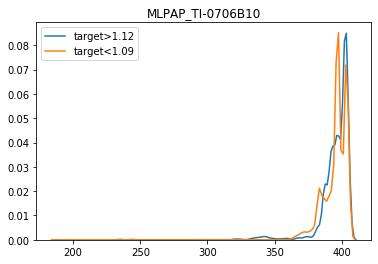

0    反應槽觸媒溫度(CL1)_高度(1310)
dtype: object


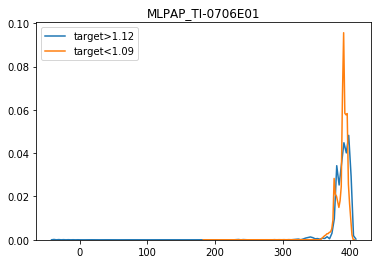

0    汽機風量
dtype: object


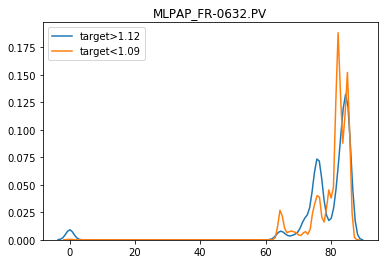

0    反應槽溫度_多點式(高度 750)
dtype: object


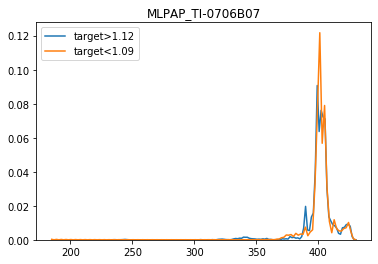

In [8]:
gc.collect()
for x_col in all_corrs.head(10).index[1:]:
  kdeplot(df,x_col,y_name)

# 可控制因子 KDEPLOT

0    OX入料量
dtype: object


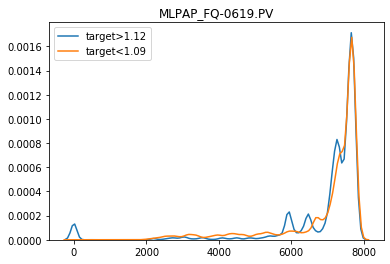

0    汽機風量
dtype: object


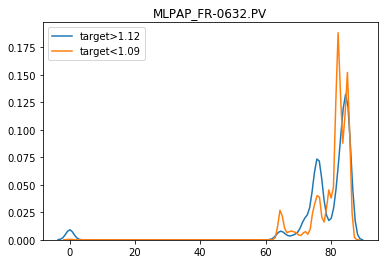

0    鹽浴冷卻器(E112)出口壓力
dtype: object


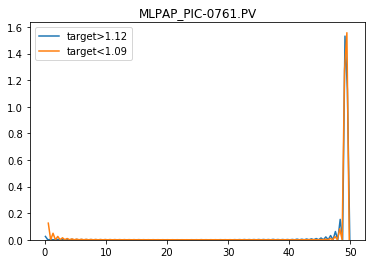

0    反應槽鹽浴溫度
dtype: object


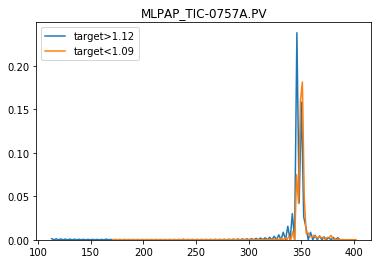

0    反應器A/B側鹽浴溫度差
dtype: object


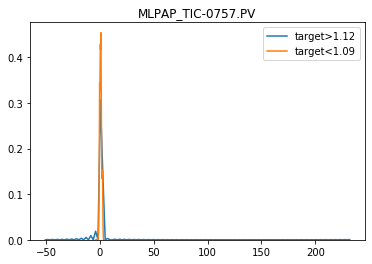

0    鹽浴冷卻器(E112)入口溫度
dtype: object


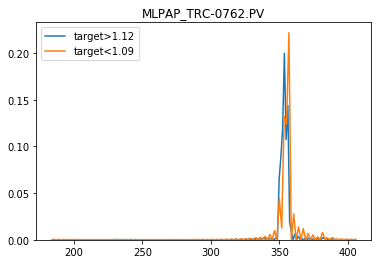

0    汽鼓(V211)鍋爐水液位
dtype: object


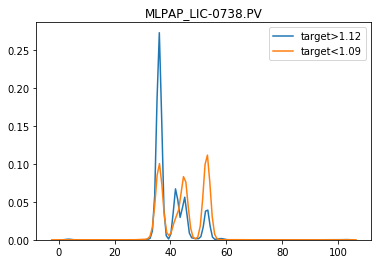

0    OX預熱器出口溫度
dtype: object


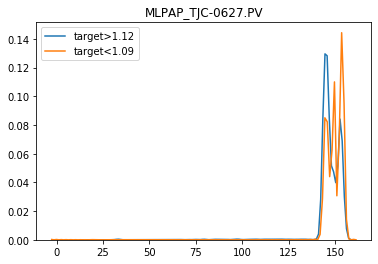

0    空氣預熱器出口溫度
dtype: object


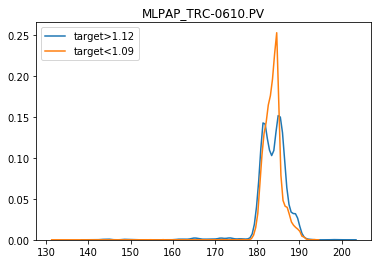

0    汽鼓(V211)鍋爐水壓力
dtype: object


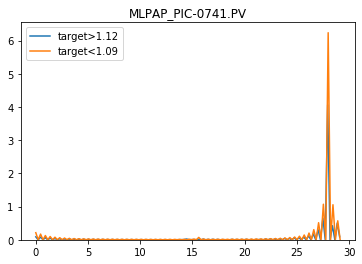

0    鍋爐水液位控制
dtype: object


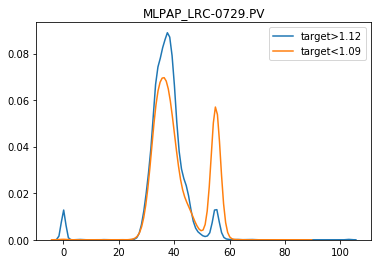

0    轉換式冷凝器熱油溫度
dtype: object


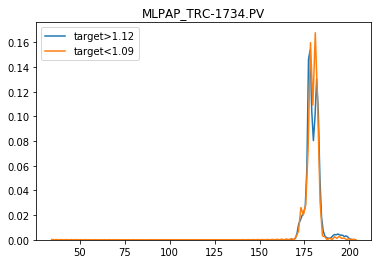

0    轉換式冷凝器冷油溫度
dtype: object


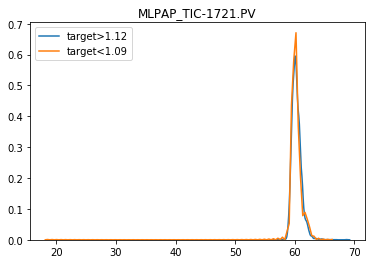

In [9]:
gc.collect()
for x_col in sub_corrs.index[1:]:
  kdeplot(df,x_col,y_name)

# correlation matrix

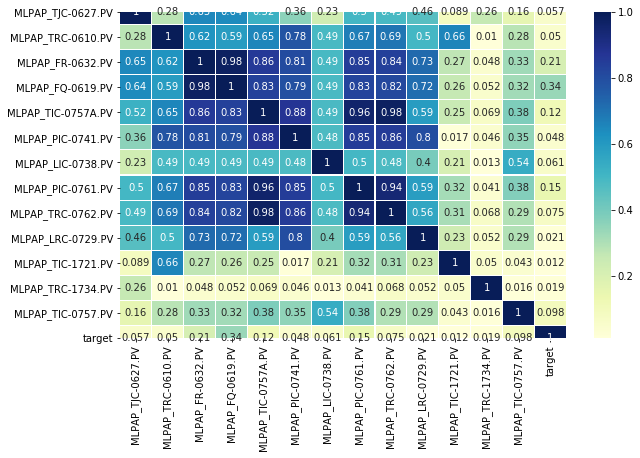

In [10]:
gc.collect()
fig = plt.figure(figsize=(10,6))
sns.heatmap(abs(df[可控制因子+[y_name]].corr()),annot=True,linewidths=0.1,cmap='YlGnBu')

# replace inf to np.nan

In [0]:
import numpy as np
df = df.replace([np.inf,-np.inf],np.nan)

# drop nan values

In [0]:
df = df.dropna()

# features selected

In [0]:
#全部特徵
#刪除y 入料 出料
#need_drop = [y_name,'MLPAP_FQI-0997.PV','MLPAP_FQ-0619.PV']
#features = df.drop(need_drop,axis=1).columns.tolist()

#部份特徵
features = 可控制因子.copy()
features.remove('MLPAP_FQ-0619.PV')

# train , test split

In [0]:
from sklearn.model_selection import train_test_split
X = df[features]
y = df[y_name]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# scaler

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train.append(X_test))
gc.collect()

0

In [0]:
X_train_ss = pd.DataFrame(scaler.transform(X_train),index = X_train.index,columns = X_train.columns)
X_test_ss = pd.DataFrame(scaler.transform(X_test),index = X_test.index,columns = X_test.columns)

# Modeling

In [0]:
# 定義超參數  
parameters = {
    'boosting_type':'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_iterations':10000,
    'early_stopping_round':40,
    }

In [18]:
import lightgbm
import numpy as np

train_data = lightgbm.Dataset(X_train_ss,label=y_train)
val_data = lightgbm.Dataset(X_test_ss,label=y_test)

model = lightgbm.train(parameters,train_data,valid_sets=[train_data, val_data])

[1]	training's rmse: 0.0836075	valid_1's rmse: 0.104573
Training until validation scores don't improve for 40 rounds.
[2]	training's rmse: 0.0791229	valid_1's rmse: 0.0998468
[3]	training's rmse: 0.0752909	valid_1's rmse: 0.095877
[4]	training's rmse: 0.0720096	valid_1's rmse: 0.0925499
[5]	training's rmse: 0.0692353	valid_1's rmse: 0.0898149
[6]	training's rmse: 0.0667708	valid_1's rmse: 0.0876387
[7]	training's rmse: 0.0647846	valid_1's rmse: 0.0857796
[8]	training's rmse: 0.0631046	valid_1's rmse: 0.0842874
[9]	training's rmse: 0.0616079	valid_1's rmse: 0.0831409
[10]	training's rmse: 0.0604237	valid_1's rmse: 0.0821451
[11]	training's rmse: 0.0592236	valid_1's rmse: 0.0812329
[12]	training's rmse: 0.0578701	valid_1's rmse: 0.0801363
[13]	training's rmse: 0.0567378	valid_1's rmse: 0.0792256
[14]	training's rmse: 0.0557928	valid_1's rmse: 0.078484
[15]	training's rmse: 0.0550181	valid_1's rmse: 0.0778802
[16]	training's rmse: 0.0543759	valid_1's rmse: 0.0773738
[17]	training's rmse: 

# features importance

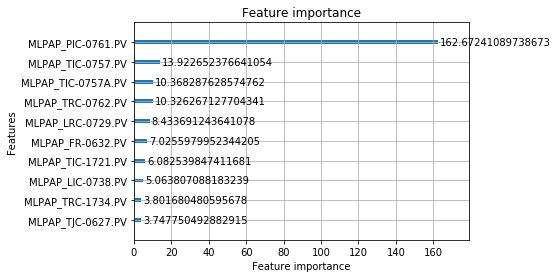

In [19]:
lightgbm.plot_importance(model,max_num_features=10,importance_type='gain')

# scoreing

In [20]:
from sklearn.metrics import r2_score,mean_squared_error
from math import sqrt

y_pred = pd.Series(model.predict(X_test_ss),name='y_pred')

res = pd.DataFrame(index=['score'])
res['R2'] = [r2_score(y_test,y_pred)]
res['mse'] = [mean_squared_error(y_test,y_pred)]
res['rmse'] = [sqrt(res['mse'])]

res

,R2,mse,rmse
score,0.559698,0.005341,0.073084


In [21]:
yt_yp = pd.DataFrame({'y_test':y_test.values,
                      'y_pred':y_pred.values,},
                      index=list(y_test.index))
yt_yp = yt_yp.sort_index()
yt_yp.head()

,y_test,y_pred
2018-11-09 18:30:00,1.103245,1.104483
2018-11-09 23:00:00,1.106435,1.096554
2018-11-10 00:00:00,1.101959,1.110658
2018-11-10 02:00:00,1.102780,1.104905
2018-11-10 03:30:00,1.103621,1.097740


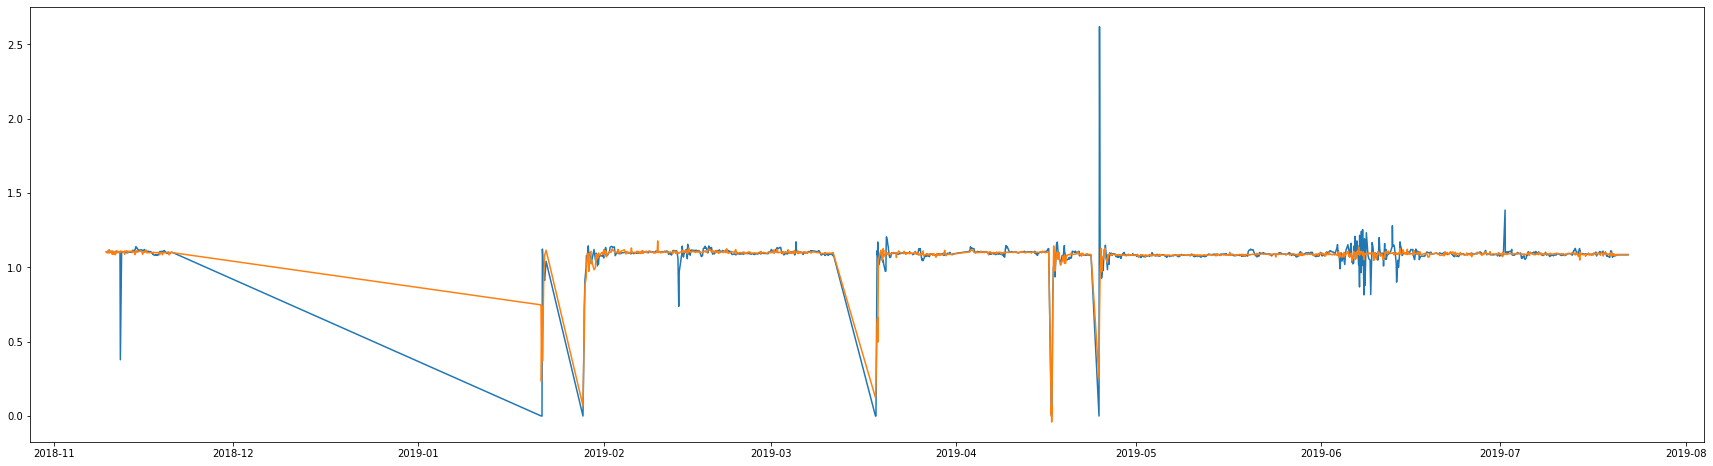

In [22]:
fig = plt.figure(figsize=(30,8))
plt.plot(yt_yp)